# Recommendation List Data Prep

This notebook does the data preparation for the recommendation list analysis.

## Setup

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan

## Load Data

Load book gender data and clean it up:

In [2]:
book_gender = pd.read_csv('data/author-gender.csv.gz')
book_gender = book_gender.set_index('item')['gender']
book_gender.loc[book_gender.str.startswith('no-')] = 'unknown'
book_gender.loc[book_gender == 'unlinked'] = 'unknown'
book_gender = book_gender.astype('category')
book_gender.describe()

count     10735373
unique           4
top        unknown
freq       6366798
Name: gender, dtype: object

In [3]:
book_gender.head()

item
101005672    unknown
101005673    unknown
101005674    unknown
101005675     female
101005676    unknown
Name: gender, dtype: category
Categories (4, object): [ambiguous, female, male, unknown]

And load hashes:

In [4]:
book_hash = pd.read_parquet('data/book-hash.parquet').rename(columns={'cluster': 'item'})
book_hash['dcode'] = book_hash['md5'].apply(lambda x: int(x[-1], 16) % 2)
book_hash = book_hash.set_index('item')
book_hash.head()

,nisbns,md5,dcode
item,,,
100000001,2,b6797168fc729b01cac4ea70ffeeb66b,1
100000002,2,a4085a8051976573c2b51d5f87d2f1d3,1
100000003,2,829f0158d2f4328e5d034ef88282f8bc,0
100000004,5,699786577b6425c7d565d1394f794a70,0
100000005,2,d0e89179cb36957e032c7884b3df4fd9,1


Load the user profile data:

In [5]:
profiles = pd.read_pickle('data/profile-data.pkl')
profiles.head()

count  linked  ambiguous  male  female  dcknown  dcyes    PropDC  \
Set user                                                                      
AZ  34891     26       6          0     0       5        3      1  0.333333   
    35841      7       7          1     0       5        3      3  1.000000   
    39018     17      10          1     3       5        7      3  0.428571   
    52563      8       8          0     0       8        4      2  0.500000   
    60825     45      38          0    31       7       18     11  0.611111   

           Known  PropFemale  PropKnown  
Set user                                 
AZ  34891      5    1.000000   0.192308  
    35841      5    1.000000   0.714286  
    39018      8    0.625000   0.470588  
    52563      8    1.000000   1.000000  
    60825     38    0.184211   0.844444

In [6]:
datasets = list(profiles.index.levels[0])
datasets

['AZ', 'BX-E', 'BX-I', 'GR-E', 'GR-I']

And load the recommendations:

In [7]:
recs = pd.read_parquet('data/study-recs.parquet')
recs.rename(columns={'dataset': 'Set', 'algorithm': 'Algorithm'}, inplace=True)
recs.head()

,Set,Algorithm,item,score,user,rank
0,BX-E,user-user,102518254,12.424905,109864,1
1,BX-E,user-user,104203137,12.424905,109864,2
2,BX-E,user-user,104700337,12.424905,109864,3
3,BX-E,user-user,110046659,12.424905,109864,4
4,BX-E,user-user,110195353,12.424905,109864,5


The original paper truncated recommendation lists to 50. Let's do that too:

In [8]:
recs = recs[recs['rank'] <= 50]

In [9]:
recs.Set.unique()

array(['BX-E', 'BX-I', 'AZ', 'GR-E', 'GR-I'], dtype=object)

In [10]:
recs.Algorithm.unique()

array(['user-user', 'item-item', 'als', 'wrls', 'bpr', 'user-user-imp',
       'item-item-imp', 'wrls-imp', 'bpr-imp'], dtype=object)

We will need to extract implicit/explicit from those.  In the new paper, we are going to separate out implicit and explicit data for presentation; these functions will help with that.

In [11]:
def select_implicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Algorithm'].str.endswith('-imp') | data['Set'].str.endswith('-I')
    data = data[implicit].assign(Set=data['Set'].str.replace('-I', ''),
                                 Algorithm=data['Algorithm'].str.replace('-imp', ''))
    data['Algorithm'] = data['Algorithm'].str.replace('wrls', 'als')
    return data

In [12]:
def select_explicit(data, reset=True):
    if reset:
        data = data.reset_index()
    implicit = data['Algorithm'].str.endswith('-imp') | data['Set'].str.endswith('-I')
    data = data[~implicit].assign(Set=data['Set'].str.replace('-E', ''))
    return data

## Analyze Rec List Composition

In the mean time, let's proceed by computing recommendation list gender data.

In [13]:
recs.drop(columns=['gender'], errors='ignore', inplace=True)
recs = recs.join(book_gender, on='item', how='left')
recs['gender'] = recs['gender'].fillna('unknown')
recs['gender'].describe()

count     978330
unique         4
top         male
freq      381966
Name: gender, dtype: object

And mix in the dummy code data:

In [14]:
recs.drop(columns=['dcode'], errors='ignore', inplace=True)
recs = recs.join(book_hash['dcode'], on='item', how='left')
recs.head()

,Set,Algorithm,item,score,user,rank,gender,dcode
0,BX-E,user-user,102518254,12.424905,109864,1,male,1.0
1,BX-E,user-user,104203137,12.424905,109864,2,female,NaN
2,BX-E,user-user,104700337,12.424905,109864,3,unknown,NaN
3,BX-E,user-user,110046659,12.424905,109864,4,male,1.0
4,BX-E,user-user,110195353,12.424905,109864,5,male,NaN


Count up the statistics for each list by gender:

In [15]:
rec_stats = recs.groupby(['Set', 'Algorithm', 'user', 'gender'])['item'].count().unstack().fillna(0).astype('i4')
rec_stats.columns = rec_stats.columns.astype('object')
rec_stats['Total'] = rec_stats.sum(axis=1)
rec_stats['Known'] = rec_stats['male'] + rec_stats['female']
rec_stats['PropKnown'] = rec_stats['Known'] / rec_stats['Total']
rec_stats['PropFemale'] = rec_stats['female'] / rec_stats['Known']
rec_stats

gender                 ambiguous  female  male  unknown  Total  Known  \
Set  Algorithm user                                                     
AZ   als       34891           0       6     8       36     50     14   
               35841           0       3     1       46     50      4   
               39018           0       1    14       35     50     15   
               52563           0       8    12       30     50     20   
               60825           1      13     8       28     50     21   
...                          ...     ...   ...      ...    ...    ...   
GR-I wrls      872560          0      24     6       20     50     30   
               873083         10       6    33        1     50     39   
               873823         11       8    30        1     50     38   
               874959         16      12    22        0     50     34   
               875836          5      12    18       15     50     30   

gender                 PropKnown  PropFemale  
Set  Algorithm user                           
AZ   als       34891        0.28    0.428571  
               35841        0.08    0.750000  
               39018        0.30    0.066667  
               52563        0.40    0.400000  
               60825        0.42    0.619048  
...                          ...         ...  
GR-I wrls      872560       0.60    0.800000  
               873083       0.78    0.153846  
               873823       0.76    0.210526  
               874959       0.68    0.352941  
               875836       0.60    0.400000  

[19840 rows x 8 columns]

Mix in info from dummy codes:

In [16]:
rec_dc_stats = recs.groupby(['Set', 'Algorithm', 'user'])['dcode'].agg(['count', 'sum', 'mean'])
rec_dc_stats.rename(columns={'count': 'dcknown', 'sum': 'dcyes', 'mean': 'PropDC'}, inplace=True)
rec_dc_stats['dcyes'] = rec_dc_stats['dcyes'].astype('i4')
rec_dc_stats.head()

dcknown  dcyes    PropDC
Set Algorithm user                           
AZ  als       34891       10      5  0.500000
              35841        3      1  0.333333
              39018        9      3  0.333333
              52563       14      5  0.357143
              60825       13      9  0.692308

In [17]:
rec_stats = rec_stats.join(rec_dc_stats)
rec_stats.head()

ambiguous  female  male  unknown  Total  Known  \
Set Algorithm user                                                    
AZ  als       34891          0       6     8       36     50     14   
              35841          0       3     1       46     50      4   
              39018          0       1    14       35     50     15   
              52563          0       8    12       30     50     20   
              60825          1      13     8       28     50     21   

                     PropKnown  PropFemale  dcknown  dcyes    PropDC  
Set Algorithm user                                                    
AZ  als       34891       0.28    0.428571       10      5  0.500000  
              35841       0.08    0.750000        3      1  0.333333  
              39018       0.30    0.066667        9      3  0.333333  
              52563       0.40    0.400000       14      5  0.357143  
              60825       0.42    0.619048       13      9  0.692308

Quick status-check on the number of recommendation lists per algorithm, implicit feedback:

In [18]:
select_implicit(rec_stats).groupby(['Set', 'Algorithm'])['Total'].count().unstack()

Algorithm,als,bpr,item-item,user-user
Set,,,,
AZ,1000,1000,1000,1000
BX,1000,1000,998,996
GR,1000,1000,1000,1000


Explicit feedback:

In [19]:
select_explicit(rec_stats).groupby(['Set', 'Algorithm'])['Total'].count().unstack()

Algorithm,als,item-item,user-user
Set,,,
AZ,1000.0,999.0,904.0
BX,1000.0,998.0,968.0
GR,NaN,1000.0,977.0


## Non-personalized Recommendations

We also want to compute the makeup of non-personalized recommendations, to get a baseline level for each algorithm.

In [20]:
az_ratings = pd.read_parquet('data/AZ/ratings.parquet')
bxi_ratings = pd.read_parquet('data/BX-I/ratings.parquet')
bxe_ratings = pd.read_parquet('data/BX-E/ratings.parquet')
gre_ratings = pd.read_parquet('data/GR-E/ratings.parquet')
gri_ratings = pd.read_parquet('data/GR-I/ratings.parquet')

In [21]:
istats = pd.concat({
    'AZ': az_ratings.groupby('item')['user'].count().nlargest(50),
    'BX-I': bxi_ratings.groupby('item')['user'].count().nlargest(50),
    'BX-E': bxe_ratings.groupby('item')['user'].count().nlargest(50),
    'GR-I': gri_ratings.groupby('item')['user'].count().nlargest(50),
    'GR-E': gre_ratings.groupby('item')['user'].count().nlargest(50)
}, names=['Set'])
istats = istats.reset_index(name='count')
istats.head()

,Set,item,count
0,AZ,104758200,21575
1,AZ,103155988,19922
2,AZ,101555762,18650
3,AZ,101610590,15105
4,AZ,102066529,13905


In [22]:
irecs = istats.join(book_gender, on='item', how='left')
irecs['gender'] = irecs['gender'].fillna('unknown')
irecs.head()

,Set,item,count,gender
0,AZ,104758200,21575,female
1,AZ,103155988,19922,female
2,AZ,101555762,18650,ambiguous
3,AZ,101610590,15105,ambiguous
4,AZ,102066529,13905,male


In [23]:
pop_gender = irecs.groupby(['Set', 'gender']).item.count().unstack().fillna(0).astype('i4')
pop_gender.columns = pop_gender.columns.astype('object')
pop_gender['Total'] = pop_gender.sum(axis=1)
pop_gender['Known'] = pop_gender['male'] + pop_gender['female']
pop_gender['PropKnown'] = pop_gender['Known'] / pop_gender['Total']
pop_gender['PropFemale'] = pop_gender['female'] / pop_gender['Known']
pop_gender

gender,ambiguous,female,male,unknown,Total,Known,PropKnown,PropFemale
Set,,,,,,,,
AZ,8,17,18,7,50,35,0.70,0.485714
BX-E,9,19,22,0,50,41,0.82,0.463415
BX-I,9,16,25,0,50,41,0.82,0.390244
GR-E,18,13,18,1,50,31,0.62,0.419355
GR-I,16,14,19,1,50,33,0.66,0.424242


## Recommendation Coverage & Diversity

We want to understand how the recommendation lists work to better understand how many items we get.

In [24]:
list_counts = recs.groupby(['Set', 'Algorithm'])['user'].nunique()
list_counts.name = 'Lists'

In [25]:
item_counts = recs.groupby(['Set', 'Algorithm'])['item'].agg(['count', 'nunique'])
item_counts.rename(columns={'count': 'Recs', 'nunique': 'Distinct'}, inplace=True)
item_counts = item_counts.join(list_counts)
item_counts['FracDistinct'] = item_counts['Distinct'] / item_counts['Recs']

What does this look like for implicit?

In [26]:
df = select_implicit(item_counts).set_index(['Algorithm', 'Set']).stack().reorder_levels([0, 2, 1]).unstack().unstack()
df

Set             AZ                                     BX                   \
              Recs Distinct   Lists FracDistinct     Recs Distinct   Lists   
Algorithm                                                                    
als        50000.0  10920.0  1000.0     0.218400  50000.0   5926.0  1000.0   
bpr        50000.0   8764.0  1000.0     0.175280  50000.0  19595.0  1000.0   
item-item  49952.0  36582.0  1000.0     0.732343  49900.0  20417.0   998.0   
user-user  49952.0  16287.0  1000.0     0.326053  49660.0   5921.0   996.0   

Set                          GR                                
          FracDistinct     Recs Distinct   Lists FracDistinct  
Algorithm                                                      
als           0.118520  50000.0   8783.0  1000.0     0.175660  
bpr           0.391900  50000.0  35683.0  1000.0     0.713660  
item-item     0.409158  50000.0   8569.0  1000.0     0.171380  
user-user     0.119231  49908.0   6420.0  1000.0     0.128637

In [27]:
print(df.to_latex())

\begin{tabular}{lrrrrrrrrrrrr}
\toprule
Set & \multicolumn{4}{l}{AZ} & \multicolumn{4}{l}{BX} & \multicolumn{4}{l}{GR} \\
{} &     Recs & Distinct &   Lists & FracDistinct &     Recs & Distinct &   Lists & FracDistinct &     Recs & Distinct &   Lists & FracDistinct \\
Algorithm &          &          &         &              &          &          &         &              &          &          &         &              \\
\midrule
als       &  50000.0 &  10920.0 &  1000.0 &     0.218400 &  50000.0 &   5926.0 &  1000.0 &     0.118520 &  50000.0 &   8783.0 &  1000.0 &     0.175660 \\
bpr       &  50000.0 &   8764.0 &  1000.0 &     0.175280 &  50000.0 &  19595.0 &  1000.0 &     0.391900 &  50000.0 &  35683.0 &  1000.0 &     0.713660 \\
item-item &  49952.0 &  36582.0 &  1000.0 &     0.732343 &  49900.0 &  20417.0 &   998.0 &     0.409158 &  50000.0 &   8569.0 &  1000.0 &     0.171380 \\
user-user &  49952.0 &  16287.0 &  1000.0 &     0.326053 &  49660.0 &   5921.0 &   996.0 &     0.119231 & 

And explicit?

In [28]:
select_explicit(item_counts).set_index(['Algorithm', 'Set']).unstack()

Recs                   Distinct                     Lists  \
Set             AZ       BX       GR       AZ       BX       GR      AZ   
Algorithm                                                                 
als        50000.0  50000.0      NaN  16164.0     69.0      NaN  1000.0   
item-item  48326.0  49741.0  49534.0  35236.0  10238.0  29452.0   999.0   
user-user  38417.0  44353.0  48587.0  31834.0  19570.0  25547.0   904.0   

                          FracDistinct                      
Set            BX      GR           AZ        BX        GR  
Algorithm                                                   
als        1000.0     NaN     0.323280  0.001380       NaN  
item-item   998.0  1000.0     0.729131  0.205826  0.594581  
user-user   968.0   977.0     0.828644  0.441233  0.525799

## Dist. Table

In [29]:
select_implicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.mean().unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.389144,0.405522,0.436977
bpr,0.382724,0.425341,0.445633
item-item,0.364534,0.454264,0.490734
user-user,0.401199,0.393445,0.422023


In [30]:
np.sqrt(select_implicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.var()).unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.302458,0.189872,0.274364
bpr,0.298222,0.269291,0.316125
item-item,0.305145,0.204459,0.238008
user-user,0.270555,0.169215,0.259903


In [31]:
select_explicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.mean().unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.379841,0.285635,NaN
item-item,0.377928,0.430288,0.395771
user-user,0.333566,0.394142,0.364067


In [32]:
np.sqrt(select_explicit(rec_stats).groupby(['Algorithm', 'Set']).PropFemale.var()).unstack()

Set,AZ,BX,GR
Algorithm,,,
als,0.154736,0.010468,NaN
item-item,0.242641,0.130458,0.238564
user-user,0.220675,0.154452,0.165785


## Rec List Distributions

Now that we have all of this, we can start to look at recommendation list distributions.  How is Proportion Female distributed?

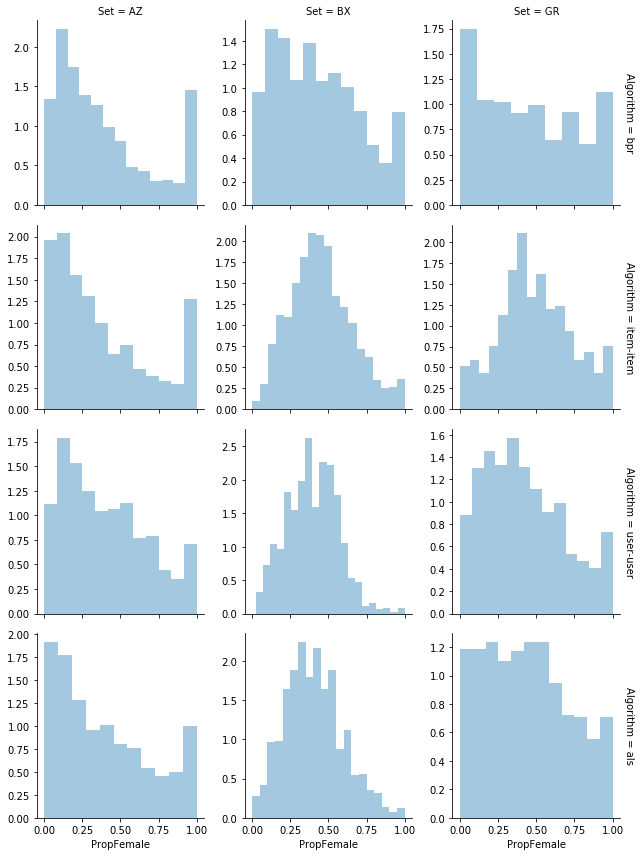

In [33]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropFemale', kde=False, norm_hist=True)

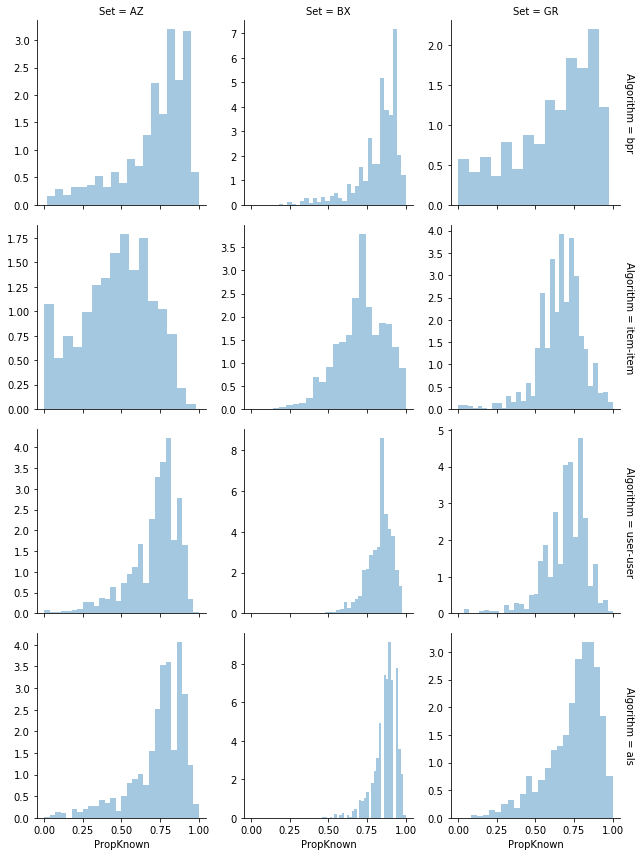

In [34]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropKnown', kde=False, norm_hist=True)

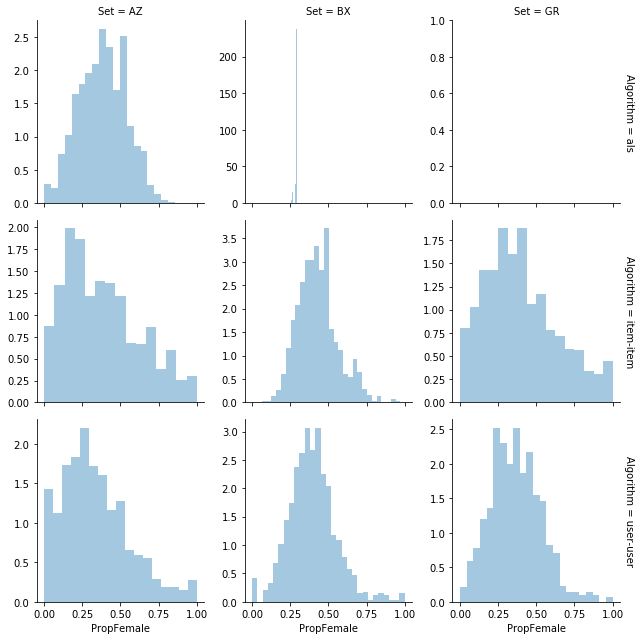

In [35]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropFemale', kde=False, norm_hist=True)

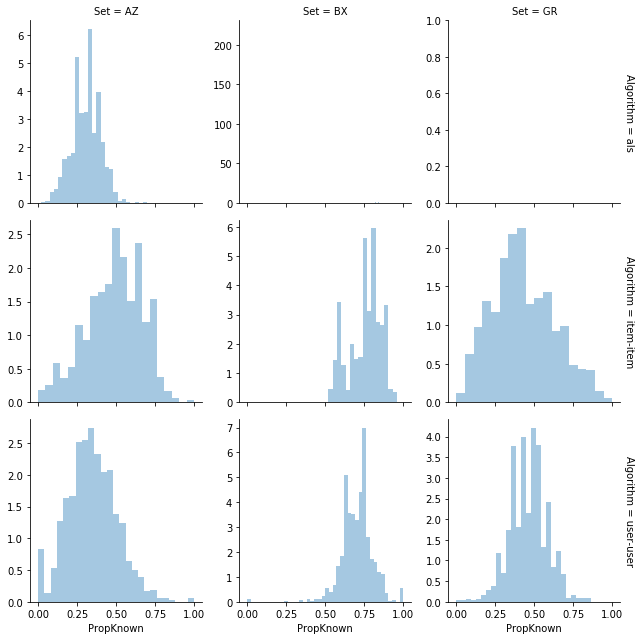

In [36]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropKnown', kde=False, norm_hist=True)

## Dummy Code Distributions

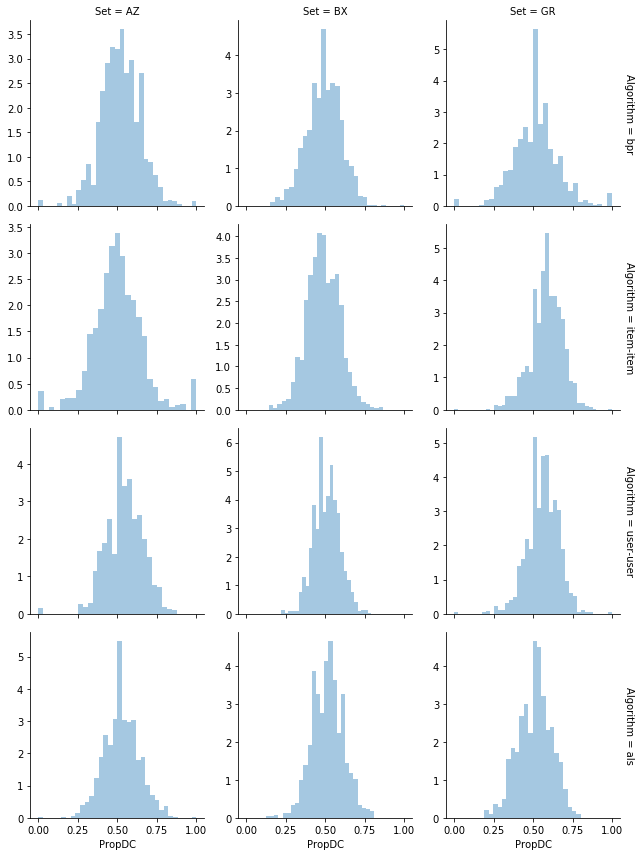

In [37]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_implicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropDC', kde=False, norm_hist=True)

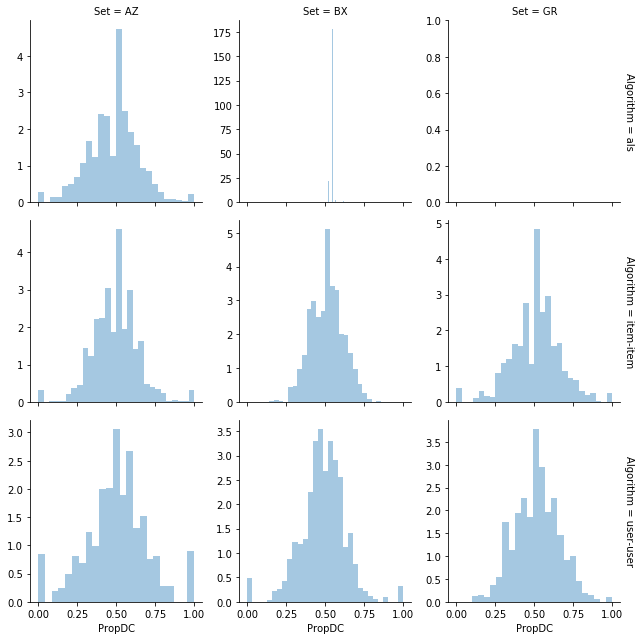

In [38]:
grid = sns.FacetGrid(col='Set', row='Algorithm', data=select_explicit(rec_stats), sharey=False, margin_titles=True)
grid.map(sns.distplot, 'PropDC', kde=False, norm_hist=True)

## Prepare for Modeling

With this analysis, we need to prepare our recommendation data for modeling.

Because ALS on BX-E behaves _so_ badly, we can't really use it. Drop from further analysis.

In [39]:
rec_stats = rec_stats.drop(('BX-E', 'als'))

In [40]:
rec_stats.to_pickle('data/rec-data.pkl')